# Sentinel-2 SAFE to Zarr Conversion

## Introduction

This notebook provides a step-by-step tutorial on converting Sentinel-2 satellite imagery from the _ESA SAFE_ format to the _cloud-native Zarr_ format using Python. The goal is to introduce users to efficient remote sensing data handling using **rioxarray**, **xarray**, and **dask**. By the end of this tutorial, users will:

* Understand the structure of SAFE format and how to extract relevant data.
* Learn how to transform and optimize satellite imagery for cloud storage.
* Visualize and compare image processing times between SAFE and Zarr formats.
* Compute vegetation indices (NDVI) from the processed data.

## Required Libraries

The following libraries are required for this workflow:

In [1]:
import os  # Operating system utilities
import dask.array as da  # Dask for parallel computation
import rioxarray as rxr  # Rioxarray for handling raster data
import xarray as xr  # Xarray for multi-dimensional data handling
import numpy as np  # NumPy for numerical operations
import matplotlib.pyplot as plt  # Matplotlib for visualization
import xml.etree.ElementTree as ET  # XML parsing for metadata extraction
from pathlib import Path  # Path utilities for file handling
from dask.diagnostics import ProgressBar  # Progress bar for Dask operations
import time  # Timing execution for performance comparison
import rasterio  # Rasterio for raster file input/output

## Step 1: Define the SAFE directory

We first specify the directory where the Sentinel-2 SAFE format data is stored.

In [10]:
safe_dir = Path('data/S2B_MSIL2A_20250307T103809_N0511_R008_T32ULC_20250307T125310.SAFE/')

## Step 2: Parse the SAFE metadata

Sentinel-2 SAFE format contains an *XML* metadata file (**_manifest.safe_**) that provides references to band file locations. We extract this information to identify where the spectral bands are stored.

In [39]:
# Parses the manifest.SAFE file for elements
tree = ET.parse(safe_dir / 'manifest.safe')
root = tree.getroot()

data_objects = root.find('dataObjectSection').findall('dataObject')

## Step 3: Extract Band File Paths

Each Sentinel-2 band is stored as a *.jp2* file inside the SAFE directory. We search for specific spectral bands and map their corresponding file paths.

In [40]:
band_files = {}
searched_bands = [
    'B02_10m', 'B03_10m', 'B04_10m', 'B05_20m', 'B06_20m', 'B07_20m', 'B08_10m',
    'B8A_20m', 'B09_60m', 'B11_60m', 'B12_60m', 'SCL_20m'
]

for data_object in data_objects:
    object_id = data_object.attrib['ID']  # The ID of the file
    file_location = data_object.find('byteStream').find('fileLocation').attrib['href']  # The path to that file

    # Searches for a match of the band name within the ID of the object
    for band in searched_bands:
        if band in object_id:
            band_files[band] = safe_dir / file_location
    
band_files

{'B02_10m': WindowsPath('data/S2B_MSIL2A_20250307T103809_N0511_R008_T32ULC_20250307T125310.SAFE/GRANULE/L2A_T32ULC_A041790_20250307T103811/IMG_DATA/R10m/T32ULC_20250307T103809_B02_10m.jp2'),
 'B03_10m': WindowsPath('data/S2B_MSIL2A_20250307T103809_N0511_R008_T32ULC_20250307T125310.SAFE/GRANULE/L2A_T32ULC_A041790_20250307T103811/IMG_DATA/R10m/T32ULC_20250307T103809_B03_10m.jp2'),
 'B04_10m': WindowsPath('data/S2B_MSIL2A_20250307T103809_N0511_R008_T32ULC_20250307T125310.SAFE/GRANULE/L2A_T32ULC_A041790_20250307T103811/IMG_DATA/R10m/T32ULC_20250307T103809_B04_10m.jp2'),
 'B08_10m': WindowsPath('data/S2B_MSIL2A_20250307T103809_N0511_R008_T32ULC_20250307T125310.SAFE/GRANULE/L2A_T32ULC_A041790_20250307T103811/IMG_DATA/R10m/T32ULC_20250307T103809_B08_10m.jp2'),
 'B05_20m': WindowsPath('data/S2B_MSIL2A_20250307T103809_N0511_R008_T32ULC_20250307T125310.SAFE/GRANULE/L2A_T32ULC_A041790_20250307T103811/IMG_DATA/R20m/T32ULC_20250307T103809_B05_20m.jp2'),
 'B06_20m': WindowsPath('data/S2B_MSIL2A_2025

## Step 4: Load Common Coordinates

Since Sentinel-2 bands have different spatial resolutions (10m, 20m, and 60m), we use the highest resolution band (B02, 10m) as the reference grid. The detailed information of how the data is stored in the SAFE format cad be found in [S2 Products](https://sentiwiki.copernicus.eu/web/s2-products).

In [12]:
# Fetch the common coordintes. Because B02 has a 10m resolution, it has the 
# best coordinates to match the others
arr_b02 = rxr.open_rasterio(
    band_files['B02_10m']
)

common_x_coords = arr_b02.coords['x']
common_y_coords = arr_b02.coords['y']

del arr_b02

## Step 5: Function to Load Bands

We create a function that loads bands into an **xarray.DataArray**, ensuring that all bands match the reference grid.

In [13]:
# Function to load a band using Dask & rioxarray
def load_band(file_path):
    """Load a Sentinel-2 band into an xarray DataArray using Dask."""
    da = rxr.open_rasterio(file_path, masked=True, chunks="auto").squeeze()
    da = da.interp(x=common_x_coords, y=common_y_coords, method='nearest', kwargs={'fill_value': 'extrapolate'})
    return da

## Step 6: Load Bands into an Xarray Dataset

Now, we load all selected bands into an xarray.Dataset.

In [14]:
# Dictionary to store bands
band_arrays = {}
for band_name, band_path in band_files.items():
    band_arrays[band_name] = load_band(band_path)

In [15]:
# Combine bands into an xarray dataset
dataset = xr.Dataset(band_arrays)

In [16]:
dataset

<xarray.Dataset> Size: 6GB
Dimensions:      (x: 10980, y: 10980)
Coordinates:
    band         int32 4B 1
    spatial_ref  int32 4B 0
  * x            (x) float64 88kB 3e+05 3e+05 3e+05 ... 4.098e+05 4.098e+05
  * y            (y) float64 88kB 5.8e+06 5.8e+06 5.8e+06 ... 5.69e+06 5.69e+06
Data variables:
    B02_10m      (y, x) float32 482MB dask.array<chunksize=(10980, 10980), meta=np.ndarray>
    B03_10m      (y, x) float32 482MB dask.array<chunksize=(10980, 10980), meta=np.ndarray>
    B04_10m      (y, x) float32 482MB dask.array<chunksize=(10980, 10980), meta=np.ndarray>
    B08_10m      (y, x) float32 482MB dask.array<chunksize=(10980, 10980), meta=np.ndarray>
    B05_20m      (y, x) float32 482MB dask.array<chunksize=(10980, 10980), meta=np.ndarray>
    B06_20m      (y, x) float32 482MB dask.array<chunksize=(10980, 10980), meta=np.ndarray>
    B07_20m      (y, x) float32 482MB dask.array<chunksize=(10980, 10980), meta=np.ndarray>
    B8A_20m      (y, x) float32 482MB dask.array<chunksize=(10980, 10980), meta=np.ndarray>
    SCL_20m      (y, x) float32 482MB dask.array<chunksize=(10980, 10980), meta=np.ndarray>
    B09_60m      (y, x) float32 482MB dask.array<chunksize=(10980, 10980), meta=np.ndarray>
    B11_60m      (y, x) float32 482MB dask.array<chunksize=(10980, 10980), meta=np.ndarray>
    B12_60m      (y, x) float32 482MB dask.array<chunksize=(10980, 10980), meta=np.ndarray>

## Step 7: Save Dataset as Zarr

To optimize storage and computation, we save the dataset in Zarr format, allowing for efficient **cloud-based** analysis.

In [17]:
# Rename spatial dimensions
dataset = dataset.rename({"x": "longitude", "y": "latitude"})

In [22]:
# Save dataset as Zarr format with Dask
zarr_store = "data/sentinel2_cube.zarr"

* The dataset is chunked to optimize storage and computational efficiency.
* Chunks of size 1024x1024 are created along the longitude and latitude dimensions.
* Why chunking?
    * Zarr format allows reading and processing only the required chunks instead of loading the entire dataset into memory.
    * This is particularly beneficial for working with large satellite datasets.

In [21]:
# Enable progress bar for Dask operations
with ProgressBar():
    dataset.chunk({"longitude": 1024, "latitude": 1024}).to_zarr(zarr_store, mode="w", compute=True)

C:\Users\Usuario\anaconda3\Lib\site-packages\zarr\api\asynchronous.py:203: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


[########################################] | 100% Completed | 89.92 s


## Step 8: Compute RGB Composite

We generate RGB visualizations from both SAFE and Zarr datasets to compare processing times.

In [33]:
# Function to normalize using percentiles to avoid dark images
def normalize(array, lower_percentile=1, upper_percentile=99):
    """Normalize array using percentile clipping to enhance contrast."""
    lower, upper = np.percentile(array, [lower_percentile, upper_percentile])
    array = da.clip(array, lower, upper)  # Clip extreme values
    return (array - lower) / (upper - lower)

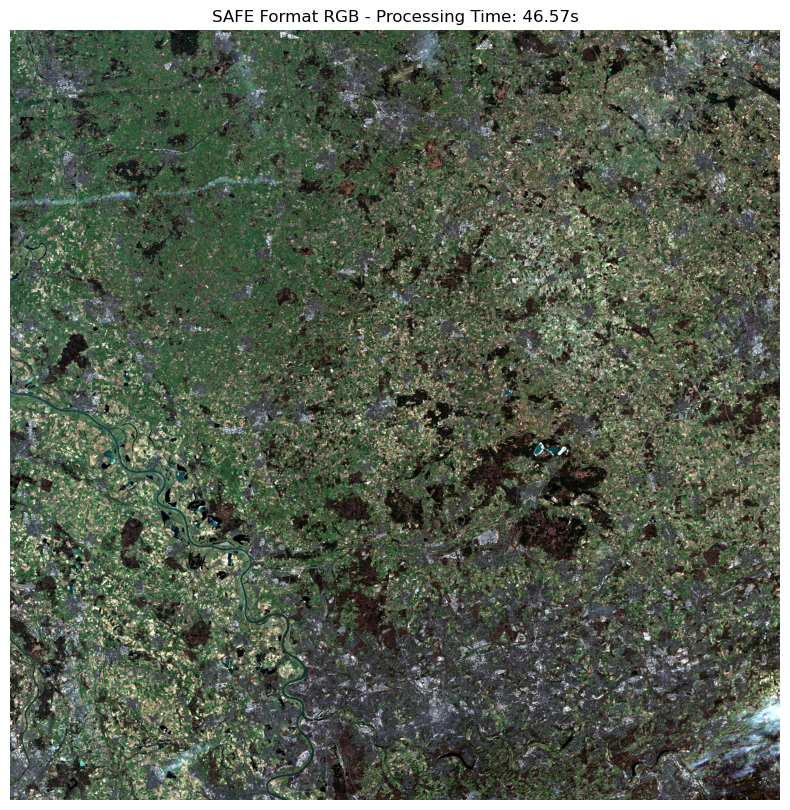

In [34]:
### **1️⃣ Compute RGB from SAFE (JP2) format**
start_safe = time.time()

# Read SAFE bands using rasterio
safe_bands = {
    "B02": band_files['B02_10m'],
    "B03": band_files['B03_10m'],
    "B04": band_files['B04_10m'],
}
safe_data = {}
for band, path in safe_bands.items():
    with rasterio.open(path) as src:
        safe_data[band] = src.read(1)  # Read full band into memory

# Stack and normalize RGB
safe_rgb = np.dstack([
    normalize(safe_data["B04"]),  # Red
    normalize(safe_data["B03"]),  # Green
    normalize(safe_data["B02"])   # Blue
])

end_safe = time.time()
safe_time = end_safe - start_safe

# Plot SAFE RGB
plt.figure(figsize=(10, 10))
plt.imshow(safe_rgb)
plt.title(f"SAFE Format RGB - Processing Time: {safe_time:.2f}s")
plt.axis("off")
plt.show()


We repeat the process for the Zarr format:

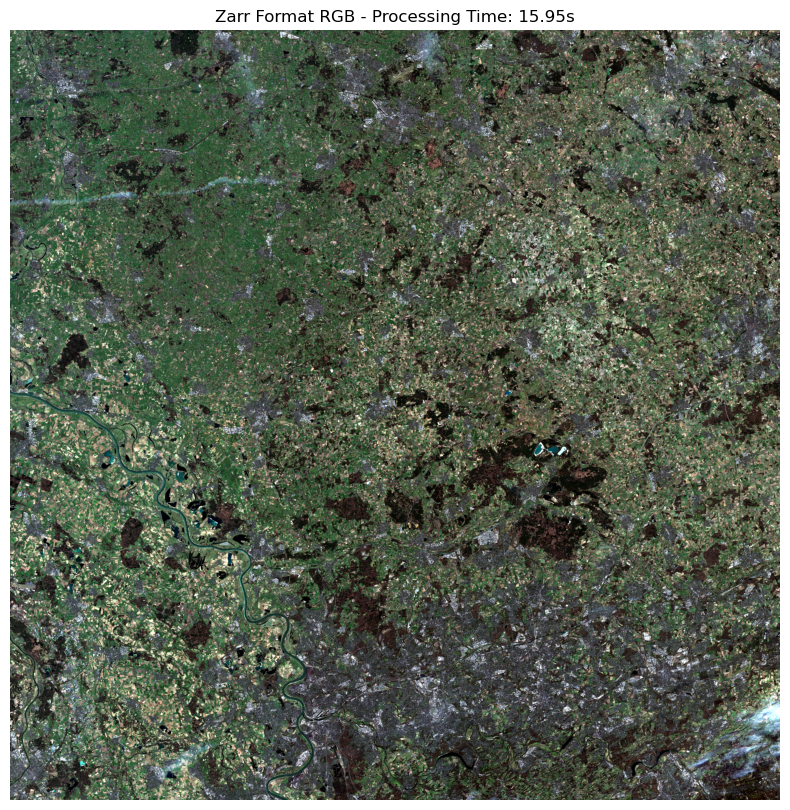

SAFE RGB Processing Time: 46.57 seconds
Zarr RGB Processing Time: 15.95 seconds
Zarr is 2.92x faster than SAFE (or slower if <1).


In [37]:
# Function to normalize using percentiles to avoid dark images
def normalize(array, lower_percentile=1, upper_percentile=99):
    """Normalize array using percentile clipping to enhance contrast."""
    lower, upper = np.percentile(array.compute(), [lower_percentile, upper_percentile])
    array = da.clip(array, lower, upper)  # Clip extreme values
    return (array - lower) / (upper - lower)
    
### Compute RGB from Zarr format
start_zarr = time.time()

# Load Zarr dataset with Dask
dataset = xr.open_zarr(zarr_store, chunks={"longitude": 1024, "latitude": 1024})

# Read Zarr bands as Dask arrays
zarr_data = {
    "B04": dataset["B04_10m"].data,
    "B03": dataset["B03_10m"].data,
    "B02": dataset["B02_10m"].data
}

# Normalize and stack RGB using Dask
zarr_rgb = da.stack([
    normalize(zarr_data["B04"]),  # Red
    normalize(zarr_data["B03"]),  # Green
    normalize(zarr_data["B02"])   # Blue
], axis=-1)

# Compute Dask array to NumPy
zarr_rgb = zarr_rgb.compute()

end_zarr = time.time()
zarr_time = end_zarr - start_zarr

# Plot Zarr RGB
plt.figure(figsize=(10, 10))
plt.imshow(zarr_rgb)
plt.title(f"Zarr Format RGB - Processing Time: {zarr_time:.2f}s")
plt.axis("off")
plt.show()

# Print performance results
print(f"SAFE RGB Processing Time: {safe_time:.2f} seconds")
print(f"Zarr RGB Processing Time: {zarr_time:.2f} seconds")
print(f"Zarr is {safe_time / zarr_time:.2f}x faster than SAFE")

## Step 9: Compute NDVI (Vegetation Index)

C:\Users\Usuario\anaconda3\Lib\site-packages\dask\core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


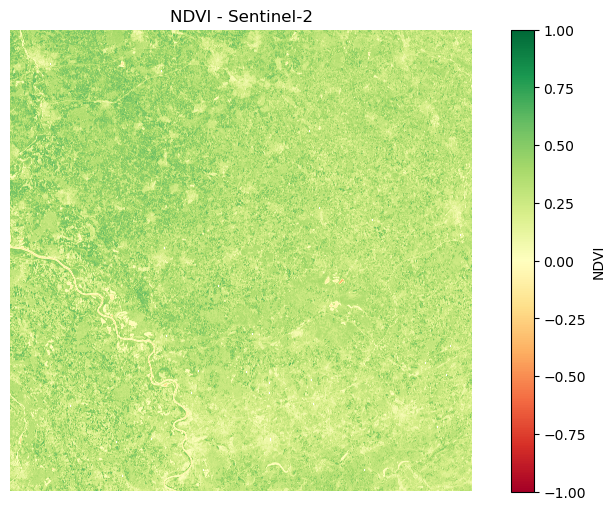

In [38]:
# Function to compute NDVI safely (avoiding division by zero)
def compute_ndvi(nir, red):
    """Compute NDVI using Dask arrays."""
    ndvi = (nir - red) / (nir + red)
    return da.where((nir + red) == 0, np.nan, ndvi)  # Handle division by zero

# Convert xarray DataArrays to Dask arrays
nir_dask = dataset["B8A_20m"].data  # Near-Infrared
red_dask = dataset["B04_10m"].data   # Red (closest available)

# Compute NDVI
ndvi_dask = compute_ndvi(nir_dask, red_dask)

# Convert from Dask to NumPy for visualization
ndvi_np = ndvi_dask.compute()

# Plot NDVI
plt.figure(figsize=(10, 6))
plt.imshow(ndvi_np, cmap="RdYlGn", vmin=-1, vmax=1)
plt.colorbar(label="NDVI")
plt.title("NDVI - Sentinel-2")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.axis("off")
plt.show()

# 📌 Summary
This function converts the xarray.Dataset to the Zarr format, ensuring:

* Efficient storage through chunking.
* Scalability for cloud-based computing.
* Faster access compared to traditional file formats like NetCDF or GeoTIFF.

# Conclusion

* SAFE format is structured but inefficient for large-scale cloud computing.

* Zarr format significantly improves access speed and performance.

* This workflow enables users to easily transition from traditional file-based remote sensing workflows to cloud-native geospatial analysis.

This tutorial serves as an introduction to using Sentinel-2 data with xarray, dask, and rioxarray. Users are encouraged to experiment with larger datasets and explore additional cloud processing options.